In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.sequence import TimeseriesGenerator

tf.__version__

'2.6.0'

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
#PREPROCESS DATA
df = pd.read_csv('clean_data.csv')
df = df.drop(['Unnamed: 0', 'BS_trend', 'date', 'hour', 'minute', 'weekday'], axis='columns')

#df = pd.get_dummies(df, columns=['weekday'])

In [4]:
#scale data
scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(df)

In [5]:
X = df_scaled
y = scaler.fit_transform(df['BS'].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

X_train.shape

(3831, 13)

In [6]:
#remove records from data to create tensors
#X_train_minmax = X_train_minmax[:len(X_train_minmax)-10]
#y_train = y_train[:len(X_train_minmax)]

In [7]:
#X_train_minmax = X_train_minmax.reshape(364, 12, 19)
#X_test_minmax = X_test_minmax.reshape(182,24,19)

In [8]:
n_input = 24
n_features = 13
train_generator = TimeseriesGenerator(X_train, y_train,sampling_rate=1, length=n_input, batch_size=32)
test_generator = TimeseriesGenerator(X_test, y_test,sampling_rate=1, length=n_input, batch_size=32)

# print(len(generator))
# batch_0 = generator[3]
# x, y = batch_0

# print("THIS IS X")
# print(x[0])
# print("THIS IS Y")
# print(y)


In [9]:


model = tf.keras.Sequential(
    [
        layers.Masking(mask_value=0.,
                       input_shape=(n_input, n_features)),
        layers.LSTM(100, 
            activation='relu',
            dropout=0.1,
            recurrent_dropout=0.5,
            return_sequences=True),
        layers.LSTM(100, 
            activation='relu',
            dropout=0.1,
            recurrent_dropout=0.5,
            return_sequences=True),
        layers.LSTM(75,
            activation='relu',
            dropout=0.1,
            recurrent_dropout=0.5,
            return_sequences=True),
        layers.LSTM(25,
            activation='relu',
            dropout=0.1,
            recurrent_dropout=0.5,
            return_sequences=False),
        layers.Dense(1, activation='relu', dtype='float64')
    ]
)



In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')
model.compile(loss='mae', optimizer='adam')
#model(X_train_minmax)
#model.summary()

In [11]:
#history = model.fit(x=X_train_minmax,y=y_train, shuffle=False, epochs=200, batch_size=24, validation_split=0.2)
history = model.fit(train_generator, validation_data=test_generator, epochs=50, shuffle=False, batch_size=32)
#history = model.fit(x=generator, shuffle=False, epochs=200, batch_size=32)

Epoch 1/50
119/119 [==============================] - 27s 124ms/step - loss: 0.1438 - val_loss: 0.0886
Epoch 2/50
119/119 [==============================] - 13s 112ms/step - loss: 0.1051 - val_loss: 0.0877
Epoch 3/50
119/119 [==============================] - 13s 112ms/step - loss: 0.0985 - val_loss: 0.0825
Epoch 4/50
119/119 [==============================] - 13s 112ms/step - loss: 0.0909 - val_loss: 0.0759
Epoch 5/50
119/119 [==============================] - 13s 111ms/step - loss: 0.0838 - val_loss: 0.0824
Epoch 6/50
119/119 [==============================] - 13s 111ms/step - loss: 0.0762 - val_loss: 0.0692
Epoch 7/50
119/119 [==============================] - 13s 113ms/step - loss: 0.0719 - val_loss: 0.0791
Epoch 8/50
119/119 [==============================] - 13s 113ms/step - loss: 0.0647 - val_loss: 0.0804
Epoch 9/50
119/119 [==============================] - 13s 113ms/step - loss: 0.0587 - val_loss: 0.0724
Epoch 10/50
119/119 [==============================] - 13s 113ms/step - l

In [12]:
predicted = model.predict(train_generator)
predicted = scaler.inverse_transform(predicted)

predicted.shape[0]

3807

In [13]:
predicted.shape

(3807, 1)

In [14]:
y_train = scaler.inverse_transform(y_train)
y_train = y_train[n_input:]
y_train.shape


(3807, 1)

In [15]:
r2_score(y_train, predicted)

0.8341123928972137

In [16]:
mean_squared_error(y_train, predicted)

281.444440290438

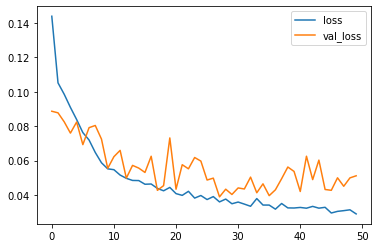

In [17]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [18]:
results_df = pd.concat( [pd.DataFrame(predicted, columns=['predicted']), pd.DataFrame(y_train, columns=['true'])], axis=1 )
results_df

,predicted,true
0,121.469777,134.0
1,118.578736,133.0
2,116.927359,134.0
3,117.351047,136.0
4,119.442839,134.0
...,...,...
3802,80.782794,87.0
3803,79.782140,85.0
3804,77.787375,83.0
3805,75.659190,79.0


<AxesSubplot:>

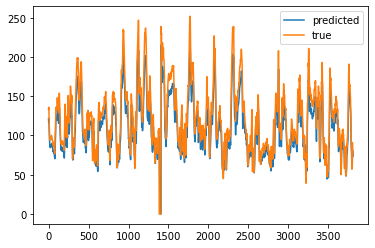

In [19]:
results_df.plot()

In [20]:
predicted = model.predict(test_generator)
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test[n_input:])

results_df = pd.concat( [pd.DataFrame(predicted, columns=['predicted']), pd.DataFrame(y_test, columns=['true'])], axis=1 )
results_df

,predicted,true
0,69.471487,76.0
1,69.086084,76.0
2,68.872704,75.0
3,68.661379,74.0
4,68.408062,71.0
...,...,...
1613,72.336351,76.0
1614,70.967066,77.0
1615,70.100352,75.0
1616,69.510201,70.0


<AxesSubplot:>

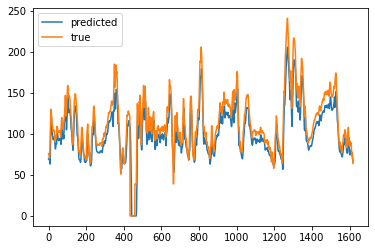

In [21]:
results_df.plot()

In [22]:
print(r2_score(predicted, y_test))
print(mean_squared_error(predicted, y_test))

0.7133089718354669
258.7312256627082
